Deep Learning (MXNET) LSTM


In [1]:
import numpy as np
import pandas as pd
import json
from datetime import datetime
from dateutil.parser import parse
import sys
sys.path.append('../')
from mlalgms.statsmodel import calculateHistoricalParameters

In [2]:
anomaly_data = pd.read_csv("../../test_data/timeserials2.csv")
print(type(anomaly_data))
### print size
print(anomaly_data.shape)
### print columns
print(anomaly_data.columns.values)

<class 'pandas.core.frame.DataFrame'>
(4032, 2)
['timestamp' 'value']


In [3]:
from mlalgms.statsmodel import detectAnomalies
from utils.converterutils import addHeader

In [4]:

idx = anomaly_data.timestamp.values
anomaly_data_ds = [parse(d) for d in idx ]
y = anomaly_data.value.values
df = addHeader (anomaly_data_ds, y)


In [5]:
from mlalgms.deeplearning import L, ctx
from mlalgms.deeplearning import createModel, trainModel, load_and_predict,calculateUpperLowerBound
from mlalgms.deeplearning import evaluate_accuracy,load

In [6]:
model, trainer = createModel(ctx, 1, 25, 0.001)
print(model)

Sequential(
  (0): LSTM(None -> 25, TNC, dropout=0.35)
  (1): LSTM(None -> 1, TNC)
)


In [7]:
from mlalgms.evaluator import ts_train_test_split


In [8]:
train_data_selected, test_data_selected  = ts_train_test_split(df, split_ratio=0.7)
print(len(test_data_selected) )
print(len(train_data_selected))
print(len(df))



1210
2822
4032


In [9]:
train = train_data_selected['y'].as_matrix().astype(np.float32)
test= test_data_selected ['y'].as_matrix().astype(np.float32)
all = df ['y'].as_matrix().astype(np.float32)
print(len(all))

4032


In [13]:
batch_size = 128
train_loader= load(train,batch_size)
test_loader = load(test, batch_size)

In [14]:
train_mse, test_mse= trainModel(train_loader, test_loader, model,trainer, ctx, 1,1,25,batch_size)
    
print(train_mse)


 #   upper = calculateThreshold(train_predicted , 2)

[0.0009453790859444543, 0.0009523217266415368, 0.000953097746589818, 0.0009308859756382172, 0.0009274181387730133, 0.0009259492585640502, 0.0009279482158529827, 0.000929365325883618, 0.0009224937497808993, 0.0009159027835978676, 0.0009134910955570218, 0.0009124214928543433, 0.0009117202461430164, 0.0009101994680310346, 0.0009076623621734578, 0.0009051719629417715, 0.0009032456268276135, 0.0009016911799335505, 0.0009002352305248246, 0.0008987305140892757, 0.0008971792319204287, 0.0008956502252539908, 0.0008941853372522496, 0.0008927834855374225, 0.0008914262537117515]


In [15]:
print(test_mse)

[0.001886696563087753, 0.0018935084906843258, 0.0018944882165669696, 0.0018725544467997682, 0.0018689091421038029, 0.0018674130420549774, 0.0018695307026064256, 0.001871182370450697, 0.0018643721890839514, 0.0018577805855784389, 0.0018554345069787814, 0.001854510863086034, 0.0018539908040111188, 0.001852637769843568, 0.001850226001079136, 0.0018478464405234263, 0.0018460454896739977, 0.0018446319253598634, 0.0018433216624544001, 0.001841958138720656, 0.0018405409622573642, 0.0018391421726846602, 0.0018378047170699574, 0.0018365292556154602, 0.0018352963889810782]


In [16]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(16, 7)

In [17]:


# Plot the training vs test mse
def plot_errors(train_mse, test_mse):
    epochs = range(len(train_mse))
    figsize(16, 7)
    plt.plot(epochs, train_mse, label='Train')
    plt.plot(epochs, test_mse, label='Test')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

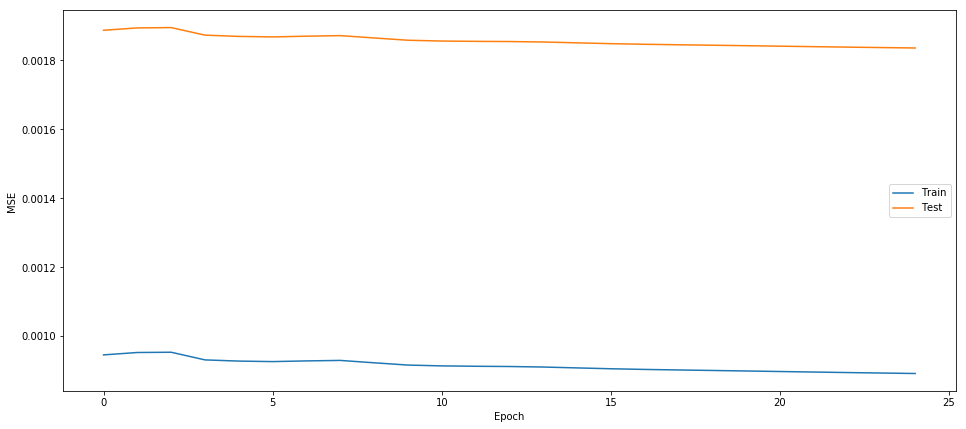

In [18]:
plot_errors(train_mse, test_mse)

In [19]:
tall= load_and_predict(all,L, model, batch_size,1)

print(len(tall))
    

4032


In [20]:
upper, lower = calculateUpperLowerBound(tall , 3)

In [21]:
print(tall, upper)

[6.82171492e-04 2.42572478e-05 3.68369656e-05 ... 1.20112481e-05
 1.19537663e-05 1.18609050e-05] 0.07408355783772745


In [22]:
print(upper,'  , ', lower)

0.07408355783772745   ,  -0.07163270485717442


In [23]:
anomaly = list(map(lambda v: v > upper, tall))

In [24]:
print(len(anomaly))

4032


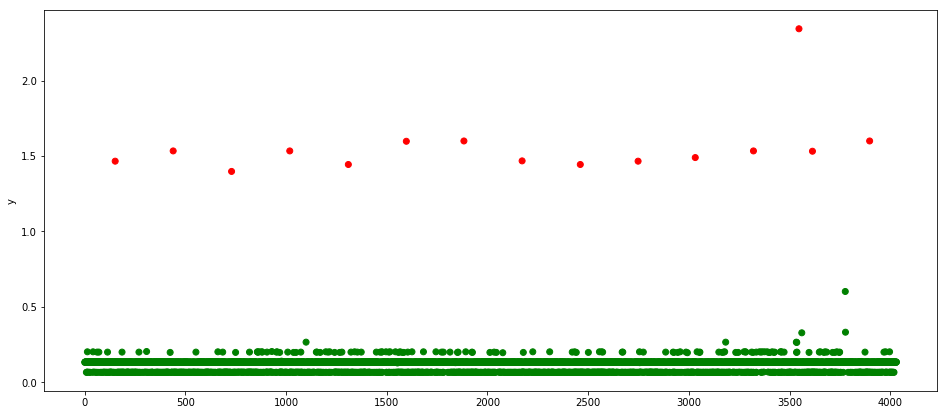

In [25]:
anomaly1 = list(map(lambda v: "red" if v else "green", anomaly))
figsize(16, 7)
plt.scatter(list(range(len(df['y']))),df['y'], c=anomaly1)
plt.ylabel('y')
plt.show()